# Fake News - EDA

In [127]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import string 

from wordcloud import WordCloud,STOPWORDS

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [2]:
# Read fake news csv
fake = pd.read_csv('../Data/fake-news/Fake.csv')
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [3]:
# Read true news csv
true = pd.read_csv('../Data/fake-news/True.csv')
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


Let us now add labels to the DataFrames, a `1` for true news and `0` for fake news.

In [4]:
# Add binary label column
fake['label'] = 0
true['label'] = 1

We now merge the two DataFrames.

In [5]:
# Merge using pd.concat
df = pd.concat([true, fake], ignore_index = True)
df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


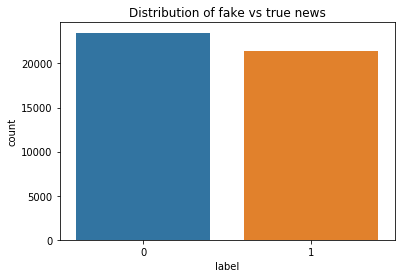

In [6]:
# Visualise class distribution
sns.countplot(df.label)
plt.title('Distribution of fake vs true news')
plt.show()

The dataset is balanced.

## Clean Data

### Investigate missing values

In [7]:
# Get info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
title      44898 non-null object
text       44898 non-null object
subject    44898 non-null object
date       44898 non-null object
label      44898 non-null int64
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [8]:
# Check missing values
df.isna().any().any()

False

There does not appear to be any missing values.

### Investigate duplicates

In [9]:
titlecounts = df.title.value_counts()
titlecounts

Factbox: Trump fills top jobs for his administration                                                     14
Factbox: Contenders for senior jobs in Trump's administration                                             8
Highlights: The Trump presidency on April 13 at 9:30 P.M. EDT/0130 GMT on Friday                          8
MEDIA IGNORES Time That Bill Clinton FIRED His FBI Director On Day Before Vince Foster Was Found Dead     6
Factbox: International reaction to arrest of Reuters reporters in Myanmar                                 6
                                                                                                         ..
Japan to expand ballistic missile defense with ground-based Aegis batteries                               1
Florida governor replaces anti-death penalty prosecutor                                                   1
Watch Judge Jeanine Offer The DEFINITIVE Criminal & Political Case Against Hillary Clinton                1
New Jersey holds governor pr

In [10]:
# Get duplicate titles, ie more than once
len(titlecounts[titlecounts>1])

5629

There are 5629 entries with the same title.

In [11]:
# Investigate most popular title
toptitledf = df[df['title'] == 'Factbox: Trump fills top jobs for his administration']
toptitledf.head()

,title,text,subject,date,label
6220,Factbox: Trump fills top jobs for his administ...,(Reuters) - U.S. President-elect Donald Trump ...,politicsNews,"January 19, 2017",1
6394,Factbox: Trump fills top jobs for his administ...,(Reuters) - U.S. President-elect Donald Trump ...,politicsNews,"January 11, 2017",1
6615,Factbox: Trump fills top jobs for his administ...,(Reuters) - U.S. President-elect Donald Trump ...,politicsNews,"December 21, 2016",1
6637,Factbox: Trump fills top jobs for his administ...,(Reuters) - President-elect Donald Trump will ...,politicsNews,"December 19, 2016",1
6655,Factbox: Trump fills top jobs for his administ...,(Reuters) - President-elect Donald Trump will ...,politicsNews,"December 17, 2016",1


In [12]:
len(df)

44898

We will drop duplicate rows.

In [13]:
df = df.drop_duplicates()
len(df)

44689

We will drop rows with same title and text (keeping the first instance.)

In [14]:
df = df.drop_duplicates(['title', 'text'])
len(df)

39105

We will also drop rows with exact same text (keeping the first instance.)

In [15]:
df = df.drop_duplicates(['text'])
len(df)

38646

### Investigate date

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38646 entries, 0 to 44119
Data columns (total 5 columns):
title      38646 non-null object
text       38646 non-null object
subject    38646 non-null object
date       38646 non-null object
label      38646 non-null int64
dtypes: int64(1), object(4)
memory usage: 1.8+ MB


Let us begin by checking whether all data in the `date` column is of the correct type and can be converted to a DateTime object.

In [17]:
try:
    df['date'] = pd.to_datetime(df['date'])
except ValueError:
    print('Values cannot be converted to DateTime')

Values cannot be converted to DateTime


Let us create a function which extracts the entries in `date` which are not a date.

In [18]:
def is_date(string):
    '''
    Checks if a string can be converted into a datetime object.
    Arguments:
    - string
    Returns:
    - True if can be converted to DateTime object
    - False otherwise
    '''
    try:
        date = pd.to_datetime(string)
        return True
    except ValueError:
        return False

In [19]:
# Apply function
df = df[df['date'].apply(is_date)]
df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [20]:
len(df)

38640

In [21]:
# Convert to date
df['date'] = pd.to_datetime(df['date'])
df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,1


In [22]:
# Describe date
df['date'].describe()

count                   38640
unique                   1010
top       2017-12-06 00:00:00
freq                      177
first     2015-03-31 00:00:00
last      2018-02-19 00:00:00
Name: date, dtype: object

The dataset description stated that the entries were from 2016 to 2017. As such let us investigate the early and later entries. 

In [23]:
df_early = df[df.date < pd.to_datetime('2016-01-01')]
df_early.head()

,title,text,subject,date,label
36146,EVERY U.S. CITIZEN TAKEN HOSTAGE IN IRAN To Be...,Just another slap in the face to US citizens. ...,politics,2015-12-31,0
36147,WATCH FUNNIEST MAN In American Politics Ridicu...,You don t want to miss this!Here s a little in...,politics,2015-12-31,0
36148,"FBI POSTS $5,000 REWARD For Person Who Committ...","Americans were warned by Attorney General, Lor...",politics,2015-12-31,0
36149,SWISS ARMY CHIEF WARNS CITIZENS About Explosiv...,Wouldn t it be great if we had someone in gove...,politics,2015-12-31,0
36150,WOW! Sarah Palin’s Stunning AZ Vacation Home G...,"It would be great if her former running mate,...",politics,2015-12-30,0


In [24]:
df_early['label'].value_counts()

0    1597
Name: label, dtype: int64

The entries prior to 01/01/2016 are all fake.

In [25]:
df_late = df[df.date > pd.to_datetime('2017-12-31')]
df_late.head()

,title,text,subject,date,label
30467,Democrat Senator Warns Mueller Not To Release ...,"According to The Hill, Democrat Senator Bob Ca...",politics,2018-02-19,0
30468,MSNBC ANCHOR Flabbergasted at What Texas Teach...,If we protect every other government building ...,politics,2018-02-19,0
30469,WATCH: SNOWFLAKES ASKED Communist Party Platfo...,Ami Horowitz is fantastic! Check out this man ...,politics,2018-02-19,0
30470,JUST IN: BADASS GENERAL JOHN KELLY Shoved Chin...,Just one more reminder of why President Trump ...,politics,2018-02-18,0
30471,DOJ’s JEFF SESSIONS Opens Investigation Into W...,Thank goodnesss Jeff Sessions is moving on fin...,politics,2018-02-18,0


In [26]:
df_late['label'].value_counts()

0    35
Name: label, dtype: int64

The entries after 31/12/17 are all fake.

## Initial EDA

In [27]:
# Create helper function for plotting
def hist_plot_per_label(df, column, title):
    '''
    Displays histogram plot for a given column, split by label.
    Arguments:
    - df, Pandas dataframe
    - column, column to plot
    - title, string
    Returns: None
    '''
    plt.figure(figsize = (15,7))
    df[df['label'] == 1][column].hist(label='True')
    df[df['label'] == 0][column].hist(alpha=0.4, label='Fake')
    plt.title(title)
    plt.legend()
    plt.show()

### Label distribution

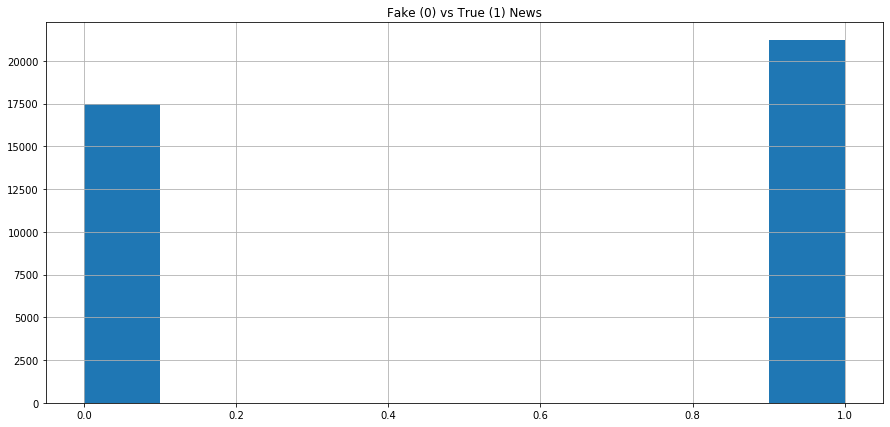

In [28]:
# Plot label distribution
plt.figure(figsize = (15, 7))
df['label'].hist()
plt.title('Fake (0) vs True (1) News')
plt.show()

### Label distribution over time

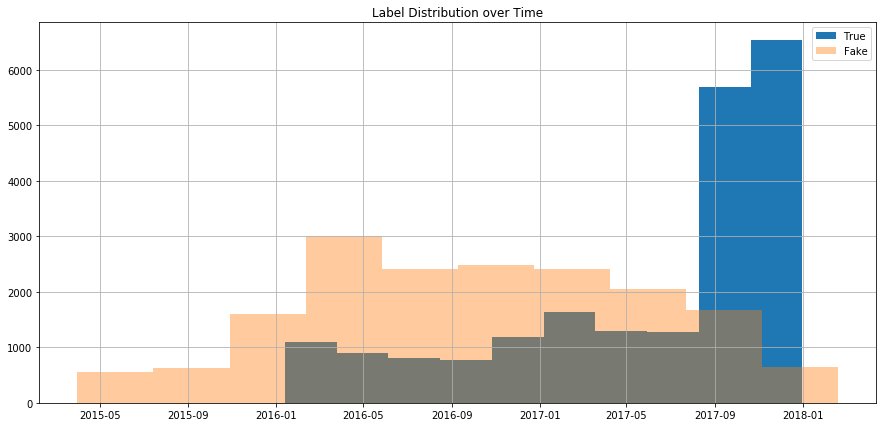

In [29]:
hist_plot_per_label(df, 'date', 'Label Distribution over Time')

### Title Length

We wonder whether the length of the title varies between true or fake news.

In [30]:
# Add title length column
df['len_title'] = df['title'].apply(len)

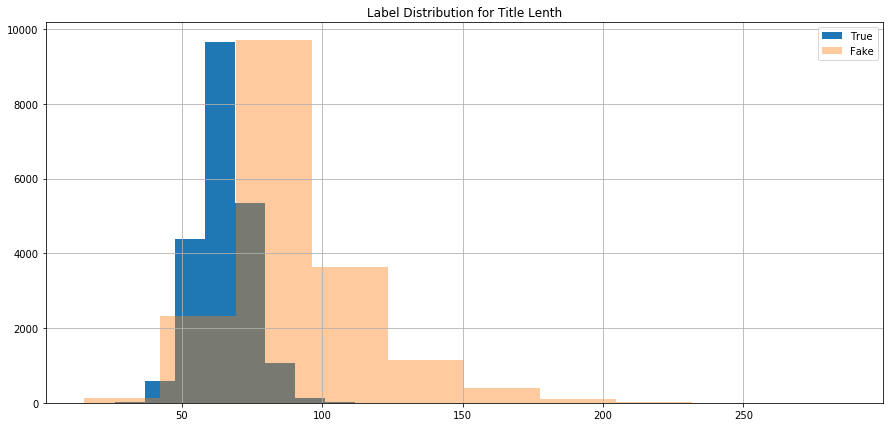

In [31]:
# Visualise
hist_plot_per_label(df, 'len_title', 'Label Distribution for Title Lenth')

In [32]:
# Describe title lenth for fake news
df[df['label'] == 0]['len_title'].describe()

count    17448.000000
mean        91.217274
std         24.504809
min         15.000000
25%         77.000000
50%         88.000000
75%        100.000000
max        286.000000
Name: len_title, dtype: float64

In [33]:
# Describe title lenth for true news
df[df['label'] == 1]['len_title'].describe()

count    21192.000000
mean        64.658598
std          9.162600
min         26.000000
25%         59.000000
50%         64.000000
75%         70.000000
max        133.000000
Name: len_title, dtype: float64

Higher variance for fake news, with std of 24. 

Also higher mean for fake news, with 91 characters vs 64 characters for true news.

### Text Length

In [34]:
# Add text length column
df['len_text'] = df['text'].apply(len)

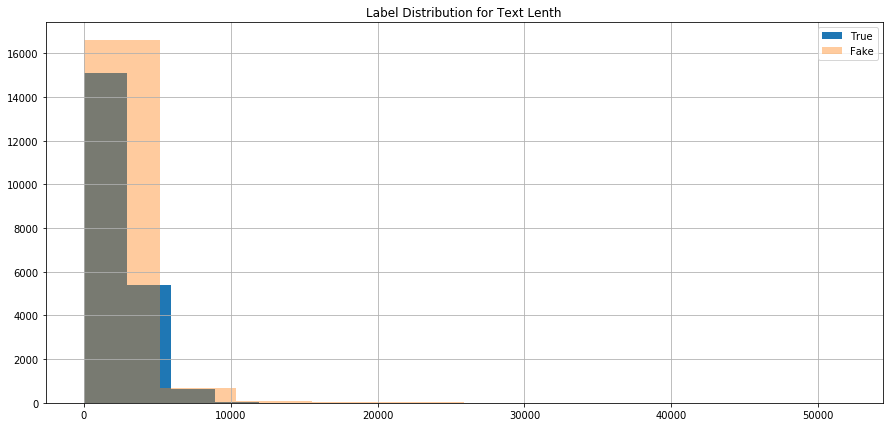

In [35]:
# Visualise
hist_plot_per_label(df, 'len_text', 'Label Distribution for Text Lenth')

In [36]:
# Describe text lenth for fake news
df[df['label'] == 0]['len_text'].describe()

count    17448.000000
mean      2550.766850
std       2201.245177
min          2.000000
25%       1650.000000
50%       2235.000000
75%       3006.000000
max      51794.000000
Name: len_text, dtype: float64

In [37]:
# Describe text lenth for true news
df[df['label'] == 1]['len_text'].describe()

count    21192.000000
mean      2378.414968
std       1683.821142
min          1.000000
25%        906.000000
50%       2216.000000
75%       3226.250000
max      29781.000000
Name: len_text, dtype: float64

Overall similar distribution.

### Presence of Capitals

In [38]:
# Create column to count number of capitals in title
df['caps_title'] = df['title'].apply(lambda x : sum(1 for char in x if char.isupper()))

# Check
df.head()

,title,text,subject,date,label,len_title,len_text,caps_title
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,1,64,4659,4
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,1,64,4077,4
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,1,60,2789,7
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,1,59,2461,8
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,1,69,5204,4


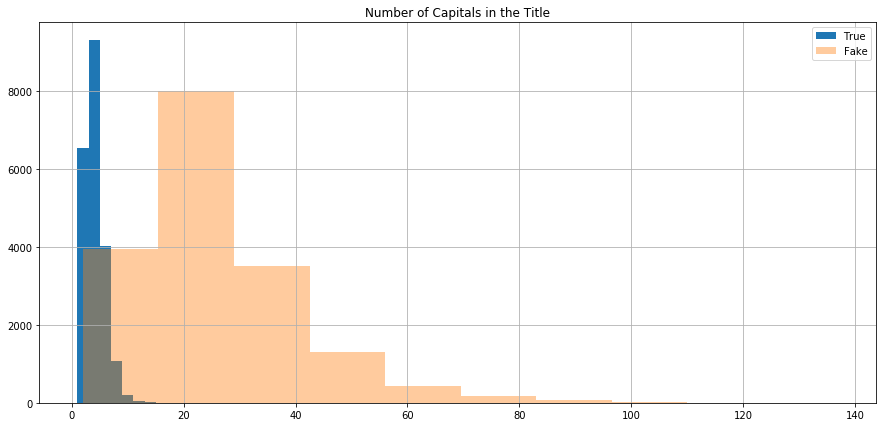

In [39]:
# Visualise
hist_plot_per_label(df, 'caps_title', 'Number of Capitals in the Title')

In [40]:
# Describe number of capitals in title for fake news
df[df['label'] == 0]['caps_title'].describe()

count    17448.000000
mean        25.689707
std         13.981860
min          2.000000
25%         16.000000
50%         22.000000
75%         32.000000
max        137.000000
Name: caps_title, dtype: float64

In [41]:
# Describe number of capitals in title for true news
df[df['label'] == 1]['caps_title'].describe()

count    21192.000000
mean         3.546102
std          1.783488
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         21.000000
Name: caps_title, dtype: float64

There are considerably more capitals in the title when looking at fake news.

Let us look at capitals in the text now.

In [42]:
# Create column to count number of capitals in title
df['caps_text'] = df['text'].apply(lambda x : sum(1 for char in x if char.isupper()))

# Check
df.head()

,title,text,subject,date,label,len_title,len_text,caps_title,caps_text
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,1,64,4659,4,155
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,1,64,4077,4,119
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,1,60,2789,7,117
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,1,59,2461,8,110
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,1,69,5204,4,200


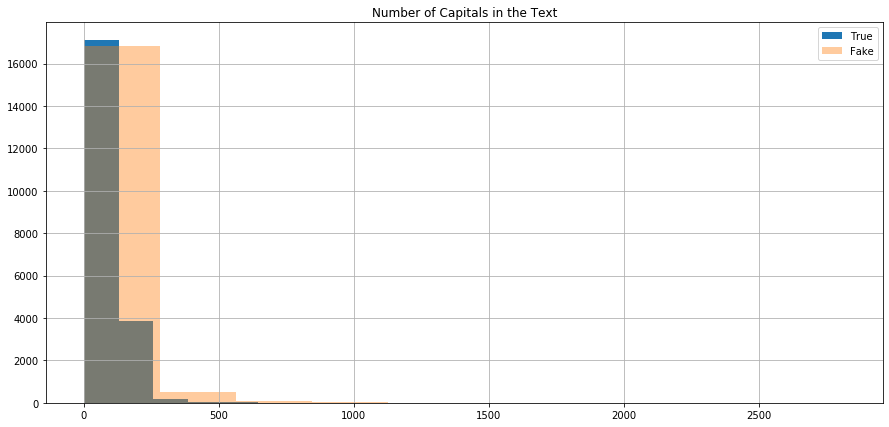

In [43]:
# Visualise
hist_plot_per_label(df, 'caps_text', 'Number of Capitals in the Text')

In [44]:
# Describe number of capitals in text for fake news
df[df['label'] == 0]['caps_text'].describe()

count    17448.000000
mean       101.091988
std         96.818908
min          0.000000
25%         56.000000
50%         80.000000
75%        116.000000
max       2818.000000
Name: caps_text, dtype: float64

In [45]:
# Describe number of capitals in text for true news
df[df['label'] == 1]['caps_text'].describe()

count    21192.000000
mean        87.348716
std         61.473809
min          0.000000
25%         41.000000
50%         76.000000
75%        115.000000
max       1291.000000
Name: caps_text, dtype: float64

Similar distribution.

### Investigate subject

In [47]:
# Get value counts
df['subject'].value_counts()

politicsNews       11214
worldnews           9978
News                9050
politics            6419
US_News              783
left-news            682
Government News      514
Name: subject, dtype: int64

Lets see the split between true/ fake news.

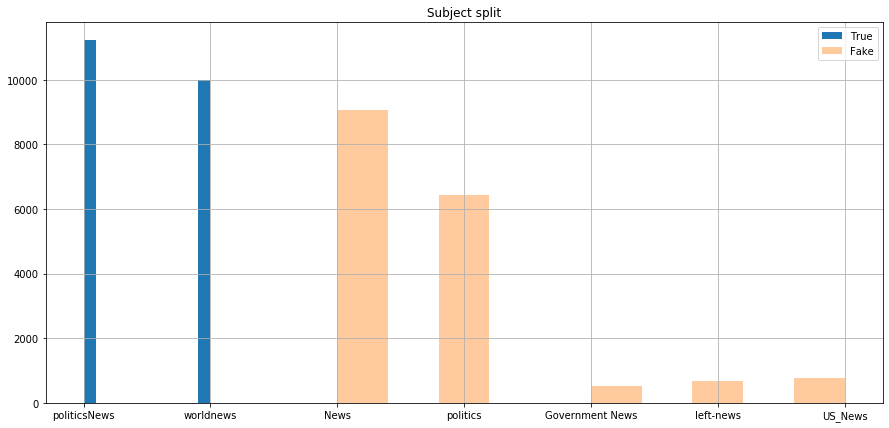

In [48]:
# Visualise
hist_plot_per_label(df, 'subject', 'Subject split')

As the subjects are different for true/ fake news we will exclude it from our analysis.

## Preprocessing

We will merge the title and text columns to create a unique feature column for our model.

In [50]:
# Create a copy
df_clean = df.copy()

# Create new text column which includes title
df_clean['text'] = df_clean['text'] + " " + df_clean['title']

# Unecessary cols
cols = ['title', 'subject', 'date', 'len_title', 'len_text', 'caps_title', 'caps_text']

# Drop unwanted columns
df_clean = df_clean.drop(cols, axis = 1)

# Check
df_clean.head()

,text,label
0,WASHINGTON (Reuters) - The head of a conservat...,1
1,WASHINGTON (Reuters) - Transgender people will...,1
2,WASHINGTON (Reuters) - The special counsel inv...,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


We will use `BeautifulSoup` to remove urls and create a function that does so for reusability.

In [57]:
# Define function to remove html
def remove_html(text):
    soup = BeautifulSoup(text, 'html.parser')
    cleantext = soup.get_text()
    return cleantext

In [58]:
# Apply function
df_clean['text'] = df_clean['text'].apply(remove_html)

In [66]:
# Preview first entry
df_clean['text'][0][:2000]

'WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support educat

We will look to remove stopwords.

In [69]:
# Define stopwords
stop = set(stopwords.words('english'))

We will create a function which returns the text without stopwords.

In [72]:
# Define function to remove stopwords
def remove_stopwords(text):
    words = []
    for word in text.split():
        if word.strip().lower() not in stop:
            words.append(word.strip())
    cleantext = " ".join(words)
    return cleantext

In [73]:
# Apply function to text
df_clean['text'] = df_clean['text'].apply(remove_stopwords)

In [75]:
# Preview first entry
df_clean['text'][0][:1000]

'WASHINGTON (Reuters) - head conservative Republican faction U.S. Congress, voted month huge expansion national debt pay tax cuts, called “fiscal conservative” Sunday urged budget restraint 2018. keeping sharp pivot way among Republicans, U.S. Representative Mark Meadows, speaking CBS’ “Face Nation,” drew hard line federal spending, lawmakers bracing battle January. return holidays Wednesday, lawmakers begin trying pass federal budget fight likely linked issues, immigration policy, even November congressional election campaigns approach Republicans seek keep control Congress. President Donald Trump Republicans want big budget increase military spending, Democrats also want proportional increases non-defense “discretionary” spending programs support education, scientific research, infrastructure, public health environmental protection. “The (Trump) administration already willing say: ‘We’re going increase non-defense discretionary spending ... 7 percent,’” Meadows, chairman small influe

Next we will remove punctuation.

In [121]:
# Define punctuation
punctuation = list(string.punctuation)
punctuation.append("“")
punctuation.append("”")
punctuation.append("’")

In [122]:
# Define function to remove punctuation
def remove_punctuation(text):
    no_punct = ""
    for char in text:
        if char not in punctuation:
            no_punct += char
    return no_punct

In [123]:
# Apply function to text
df_clean['text'] = df_clean['text'].apply(remove_punctuation)

In [124]:
# Preview first entry
df_clean['text'][0][:1000]

'WASHINGTON Reuters  head conservative Republican faction US Congress voted month huge expansion national debt pay tax cuts called fiscal conservative Sunday urged budget restraint 2018 keeping sharp pivot way among Republicans US Representative Mark Meadows speaking CBS Face Nation drew hard line federal spending lawmakers bracing battle January return holidays Wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy even November congressional election campaigns approach Republicans seek keep control Congress President Donald Trump Republicans want big budget increase military spending Democrats also want proportional increases nondefense discretionary spending programs support education scientific research infrastructure public health environmental protection The Trump administration already willing say ‘Were going increase nondefense discretionary spending  7 percent Meadows chairman small influential House Freedom Caucus said program Now D

We will save the cleaned dataset as a `.csv` file.

In [125]:
df_clean.to_csv('../Data/fake-news/data_clean.csv')

## Further EDA

### Word Clouds

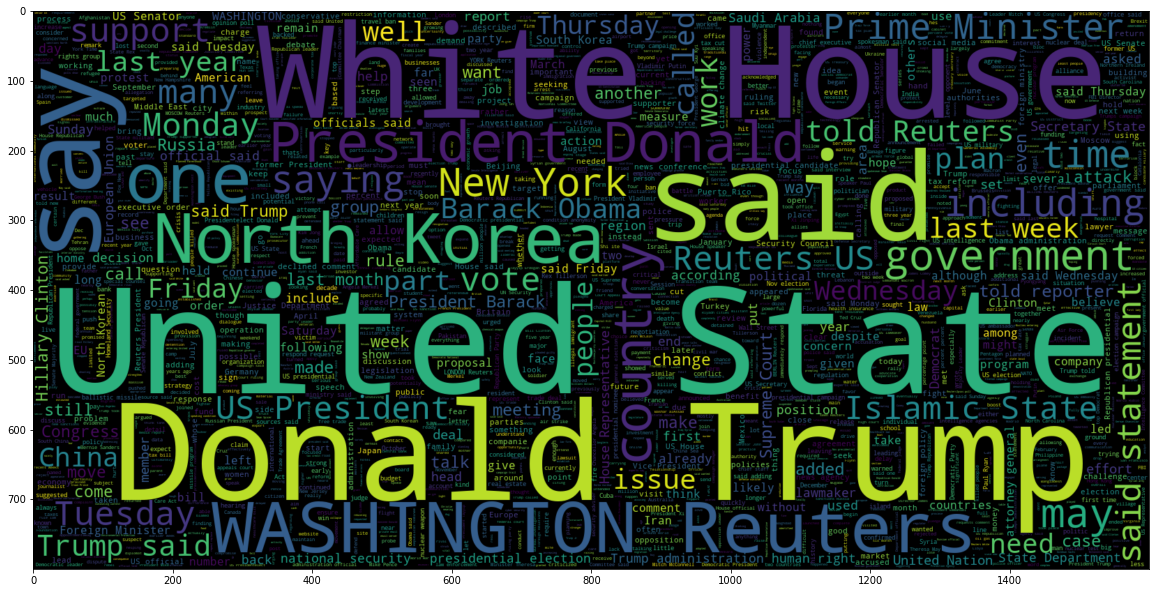

In [128]:
# Plot Word Cloud for true news
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df_clean[df_clean.label == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

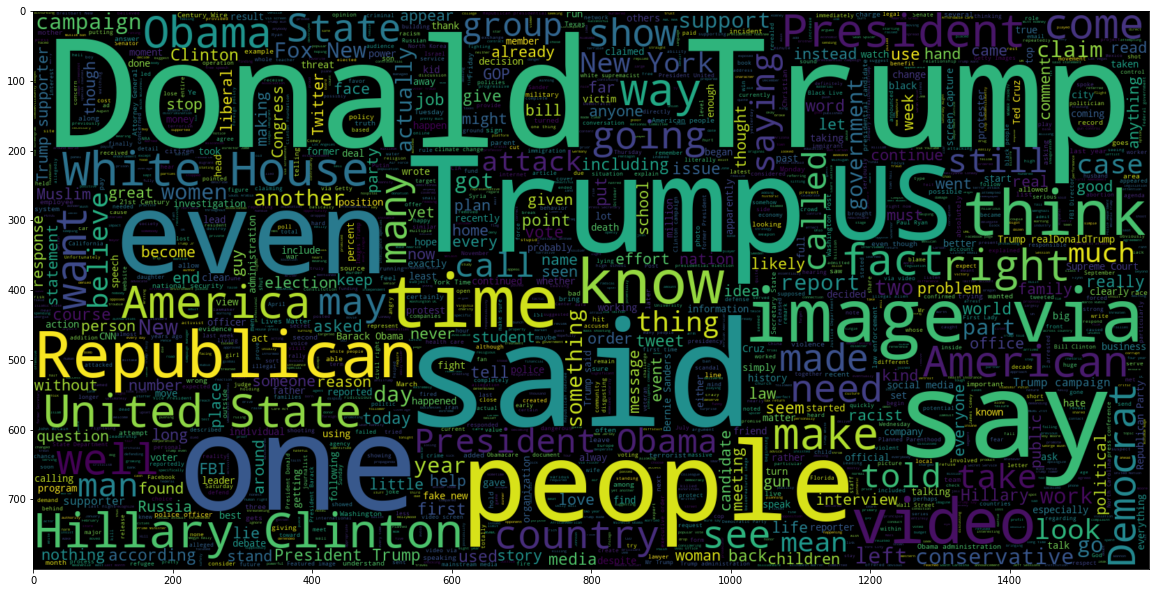

In [129]:
# Plot Word Cloud for fake news
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df_clean[df_clean.label == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

### Analysing N-grams

In [131]:
# Define function to get corpus ie words
def get_corpus(text):
    words = []
    for item in text:
        for char in item.split():
            words.append(char.strip())
    return words